In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pytensor
import pytensor.tensor as pt
from pytensor.graph import Apply, Op
from pytensor.link.jax.dispatch import jax_funcify

import jax
import jax.numpy as jnp
import diffrax
import nutpie

import pymc as pm
import arviz

/home/adr/.cache/rattler/cache/envs/ode-poc-9236526969384216065/envs/default/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n_time_points = 20

def sol_op_jax(y0, p):
    vector_field = lambda t, y, args: -y * p
    term = diffrax.ODETerm(vector_field)
    solver = diffrax.Dopri5()
    saveat = diffrax.SaveAt(ts=np.arange(n_time_points))
    stepsize_controller = diffrax.PIDController(rtol=1e-5, atol=1e-5)

    sol = diffrax.diffeqsolve(
        term,
        solver,
        t0=0,
        t1=n_time_points,
        dt0=0.1,
        y0=y0,
        saveat=saveat,
        max_steps=4096,
        stepsize_controller=stepsize_controller
    )

    return sol.ys


class SolOp(Op):
    __props__ = ("_solve_function",)
    
    def __init__(self, solve_function):
        self._solve_function = solve_function
    
    def make_node(self, y0, p):
        inputs = [pt.as_tensor_variable(y0), pt.as_tensor_variable(p)]
        # Assume the output to always be a float64 vector
        outputs = [pt.vector(dtype="float64", shape=(n_time_points,))]
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        (y0,) = inputs
        result = jax.jit(self._solve_function)
        outputs[0][0] = np.asarray(result, dtype="float64")


sol_op = SolOp(sol_op_jax)

@jax_funcify.register(SolOp)
def sol_op_jax_funcify(op, **kwargs):
    return op._solve_function

In [3]:
true_values = np.exp(-np.arange(20) * 0.1)

y = true_values + np.random.randn(20) * 0.05

#np.array([1, 0.367, 0.13, 0.05])

with pm.Model() as model:
    y0 = pm.HalfNormal("y0")
    p = pm.Beta("p", 1, 1)
    ys = sol_op(y0, p)
    sigma = pm.HalfNormal("sigma")
    pm.Normal("y", mu=ys, sigma=sigma, observed=y)

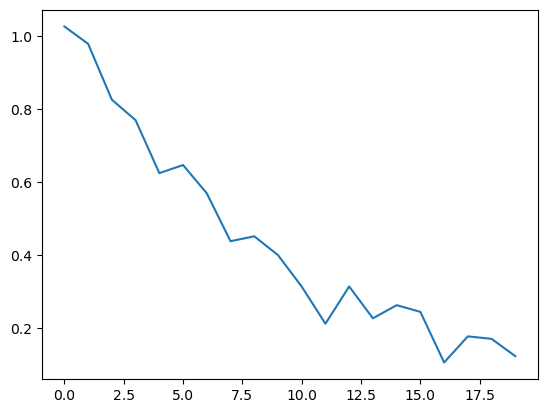

In [4]:
plt.plot(y)

In [5]:
compiled = nutpie.compile_pymc_model(model, backend="jax", gradient_backend="jax")

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [6]:
tr = nutpie.sample(compiled)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,0,0.69,3
,1300,0,0.75,3
,1300,0,0.70,7
,1300,0,0.72,7
,1300,0,0.79,7
,1300,0,0.69,5


array([[<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>]],
      dtype=object)

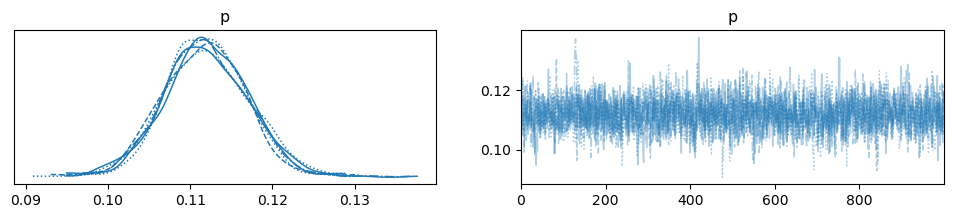

In [7]:
arviz.plot_trace(tr.posterior.p)

array([[<Axes: title={'center': 'y0'}>, <Axes: title={'center': 'y0'}>]],
      dtype=object)

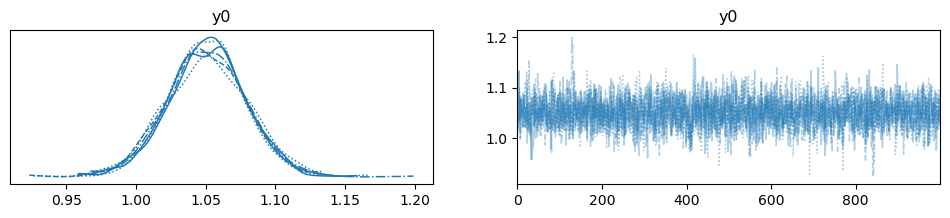

In [8]:
arviz.plot_trace(tr.posterior.y0)

array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

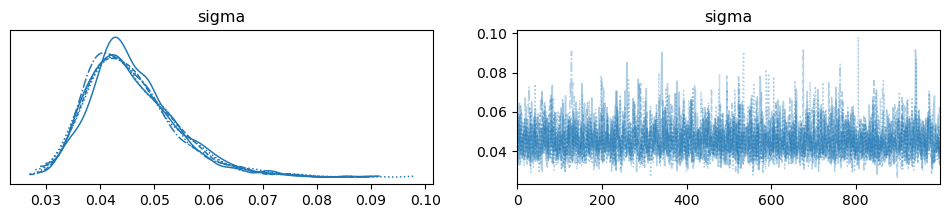

In [9]:
arviz.plot_trace(tr.posterior.sigma)